# Decompacting stratigraphic layers

In this example we visualize the decompaction of stratigraphic layers at a shallow continental drill site location, and overlay tectonic subsidence to compare its subsidence contribution with that of sedimentation.

The drill site has recorded paleo-water depths which we backstrip to reveal tectonic subsidence, at the same time decompacting the sediment layers.


## Reference

The following paper covers the theory and algorithms of pyBacktrack:

* Müller, R. D., Cannon, J., Williams, S. and Dutkiewicz, A., 2018,
  PyBacktrack 1.0: A Tool for Reconstructing Paleobathymetry on Oceanic and Continental Crust,
  **Geochemistry, Geophysics, Geosystems,** 19, 1898-1909, doi: [10.1029/2017GC007313](https://doi.org/10.1029/2017GC007313)

## Function to gather the depths of decompacted stratigraphic layers

This function accumulates the decompacted thicknesses of stratigraphic layers at each age.
This is so we know the depth of each decompacted sediment layer below sea level.

In [1]:
import pybacktrack

def get_decompacted_sediment_depths(
        well,
        decompacted_well):
    """
    Return the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # 'decompacted_wells' is a list of pybacktrack.DecompactedWell.
    # Extract the age, water depth, tectonic subsidence and
    # decompacted depths of each stratigraphic layer in the well.
    ages = []
    sea_level_depths = []
    surface_sediment_depths = []
    tectonic_subsidences = []

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(well.stratigraphic_units)
    # Each stratigraphic layer will have its own depth vs age curve.
    # Start with an empty list for each layer.
    all_stratigraphic_unit_depths = [[] for i in range(num_stratigraphic_units)]

    # Each successive decompacted well involves stripping off a stratigraphic layer.
    for decompacted_well in decompacted_wells:
        # Keep track of the ages of the top of each stratigraphic layer.
        age = decompacted_well.get_age()
        ages.append(age)

        # Keep track of the sea level (relative to present day) at each age.
        #
        # NOTE: Positive values represent sea-level rise which is the opposite of depth
        # (which is positive going down).
        # So we need to negate sea level to turn a rise into a depth.
        sea_level = decompacted_well.get_sea_level()
        sea_level_depth = -sea_level
        sea_level_depths.append(sea_level_depth)

        # Keep track of the surface sediment depth at each age.
        water_depth = decompacted_well.get_water_depth()
        surface_sediment_depth = sea_level_depth + water_depth
        surface_sediment_depths.append(surface_sediment_depth)

        # Keep track of the tectonic subsidence at each age.
        tectonic_subsidence = decompacted_well.get_tectonic_subsidence()
        tectonic_subsidences.append(tectonic_subsidence)

        # The number of decompacted stratigraphic layers decreases by one each loop iteration.
        num_decompacted_stratigraphic_units = len(decompacted_well.decompacted_stratigraphic_units)

        # The depth of the current surface layer starts at the surface sediment depth.
        total_decompacted_depth = surface_sediment_depth

        # Iterate over the stratigraphic layers that have already been removed.
        # We'll just give them the current surface sediment depth so
        # we can easily fill colours between curves below.
        stratigraphic_unit_index = 0
        while stratigraphic_unit_index < num_stratigraphic_units - num_decompacted_stratigraphic_units:
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(surface_sediment_depth)
            stratigraphic_unit_index += 1

        # Iterate over the stratigraphic layers still existing at the current time.
        # Each layer has a decompacted thickness which adds to the decompacted depth.
        for decompacted_stratigraphic_unit in decompacted_well.decompacted_stratigraphic_units:
            total_decompacted_depth += decompacted_stratigraphic_unit.decompacted_thickness
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(total_decompacted_depth)
            stratigraphic_unit_index += 1
        
    return ages, sea_level_depths, surface_sediment_depths, tectonic_subsidences, all_stratigraphic_unit_depths

## Function to plot decompacted stratigraphic layers and tectonic subsidence

This function plots a "depth vs age" curve for each stratigraphic layer in the drill site. It also plots the tectonic subsidence.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

# Choose a colour for each stratigraphic unit.
stratigraphic_unit_colours = [
    'mistyrose', 'bisque', 'lemonchiffon', 'lightgreen', 'aquamarine', 'powderblue', 'lavender', 'thistle']

def plot_decompacted_sediment_depths(
        ages,
        sea_level_depths,
        surface_sediment_depths,
        tectonic_subsidences,
        all_stratigraphic_unit_depths):
    """
    Plot the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(all_stratigraphic_unit_depths)
    
    fig = plt.figure(figsize=(8,8))

    for stratigraphic_unit_index in range(num_stratigraphic_units):
        # Plot a grey line at the top of the current stratigraphic unit.
        plt.plot(
            ages,
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            color='grey',
            linewidth=1.0)
        # Fill the current stratigraphic layer with a colour.
        plt.fill_between(
            ages,
            (all_stratigraphic_unit_depths[stratigraphic_unit_index-1]
                 if stratigraphic_unit_index > 0
                 else surface_sediment_depths),
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            facecolor=stratigraphic_unit_colours[stratigraphic_unit_index % len(stratigraphic_unit_colours)])

    # Fill blue from sea-level depth down to surface sediment depth to indicate water.
    plt.fill_between(
        ages,
        sea_level_depths,
        surface_sediment_depths,
        facecolor='royalblue')

    # Plot surface sediment depth.
    plt.plot(
        ages,
        surface_sediment_depths,
        color='black',
        label='surface sediment',
        linestyle='-',
        linewidth=2.0)

    # Plot tectonic subsidence.
    plt.plot(
        ages,
        tectonic_subsidences,
        color='black',
        label='tectonic subsidence',
        linestyle='--',
        linewidth=2.0)

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.ylabel('Depth (m)', fontsize=12)
    plt.xlabel('Age (Ma)', fontsize=12)
    plt.grid(linestyle='--',alpha=0.5)

    plt.legend(fontsize=10)

    plt.show()

## Calculate decompacted stratigraphic layers and tectonic subsidence

Here we use the [pybacktrack.backstrip_well](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.backstrip_well) function to find the tectonic subsidence for each age in the well site and the decompacted sediment thicknesses. It returns a list of [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) and from each one we can extract an age, a tectonic subsidence and the decompacted depths of the stratigraphic layers.

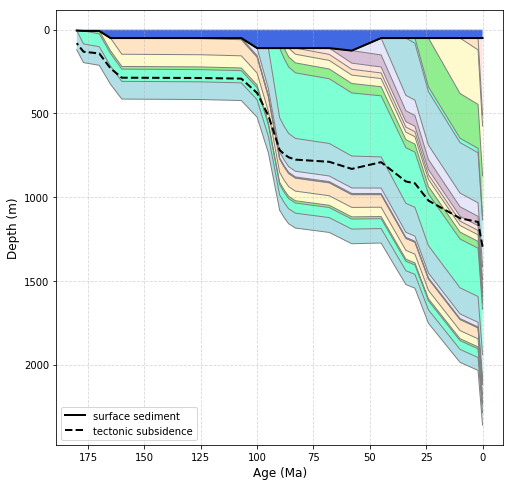

In [3]:
import warnings
# Ignore user warnings related to well thickness being larger than total sediment thickness.
warnings.simplefilter("ignore", UserWarning)

#
# Each drill site file specifies then depths, ages and lithologies of its stratigraphic layers.
#
# A shallow continental drill site file used with backstripping.
backstrip_well_filename = '../test_data/sunrise_lithology.txt'

# Backstrip to find the tectonic subsidence for each age in the well site.
well, decompacted_wells = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_wells))

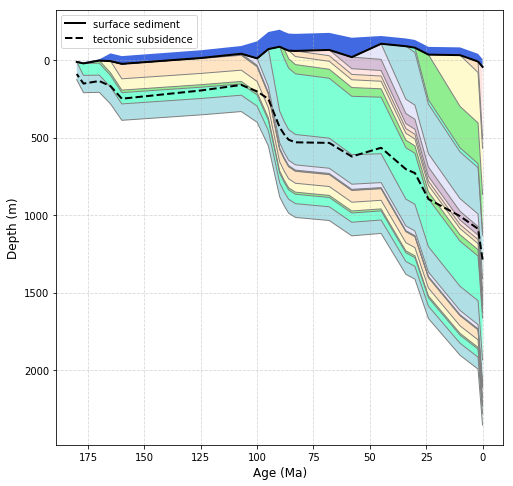

In [4]:
#
# Backstrip again, but this time with a sea level model.
#
well, decompacted_wells = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    sea_level_model='Haq87_SealevelCurve_Longterm')

# Retrieve and plot the decompacted sediment depths, etc.
plot_decompacted_sediment_depths(*get_decompacted_sediment_depths(well, decompacted_wells))